# 高维数据密度估计 - Digits 数据集


- 使用 4 个密度估计模型：DensityForest, Single Gaussian, GMM, KDE
- 计算 MMD²（SE 核和 IMQ 核）
- 可视化生成的数字
- 使用 RandomForest 评估可辨识性

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter



from density_forest import DensityForest

## 1. MMD² 计算函数

In [3]:
def rbf_kernel(X, Y, gamma=None):
    """SE核: k(x,y) = exp(-gamma * ||x-y||²)"""
    if gamma is None:
        gamma = 1.0 / (2 * X.shape[1])
    
    XX = np.sum(X**2, axis=1).reshape(-1, 1)
    YY = np.sum(Y**2, axis=1).reshape(1, -1)
    XY = X @ Y.T
    
    distances_sq = np.maximum(XX - 2*XY + YY, 0)
    return np.exp(-gamma * distances_sq)


def imq_kernel(X, Y, c=1.0, beta=0.5):
    """IMQ 核: k(x,y) = (c² + ||x-y||²)^(-beta)"""
    XX = np.sum(X**2, axis=1).reshape(-1, 1)
    YY = np.sum(Y**2, axis=1).reshape(1, -1)
    XY = X @ Y.T
    
    distances_sq = np.maximum(XX - 2*XY + YY, 0)
    return np.power(c**2 + distances_sq, -beta)


def compute_mmd_squared(X, Y, kernel_type='rbf', **kernel_params):
    """计算 MMD²（Maximum Mean Discrepancy）"""
    if kernel_type == 'rbf':
        K_XX = rbf_kernel(X, X, **kernel_params)
        K_YY = rbf_kernel(Y, Y, **kernel_params)
        K_XY = rbf_kernel(X, Y, **kernel_params)
    elif kernel_type == 'imq':
        K_XX = imq_kernel(X, X, **kernel_params)
        K_YY = imq_kernel(Y, Y, **kernel_params)
        K_XY = imq_kernel(X, Y, **kernel_params)
    
    n, m = K_XX.shape[0], K_YY.shape[0]
    
    # 无偏估计：排除对角线
    term1 = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    term2 = (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    term3 = K_XY.mean()
    
    return term1 + term2 - 2 * term3

## 2. 可视化函数

In [4]:
def visualize_digits_grid(samples, title="Generated Digits", n_rows=4, n_cols=10, figsize=(15, 6)):
    """
    改进的网格显示：按预测类别组织，每行显示同一类别的数字
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i in range(n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        
        if i < len(samples):
            digit = samples[i].reshape(8, 8)
            digit = np.clip(digit, 0, 16)
            axes[row, col].imshow(digit, cmap='gray_r', vmin=0, vmax=16)
        
        axes[row, col].axis('off')
    
    plt.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


'''def visualize_by_class(generated_samples, clf, model_name, samples_per_class=10):
    """
    按分类器预测的类别组织显示生成的数字
    每行显示同一个数字类别的多个样本
    """
    predictions = clf.predict(generated_samples)
    
    fig, axes = plt.subplots(10, samples_per_class, figsize=(15, 15))
    
    for digit in range(10):
        # 找到被预测为该数字的样本
        indices = np.where(predictions == digit)[0]
        
        for j in range(samples_per_class):
            if j < len(indices):
                idx = indices[j]
                img = generated_samples[idx].reshape(8, 8)
                img = np.clip(img, 0, 16)
                axes[digit, j].imshow(img, cmap='gray_r', vmin=0, vmax=16)
            else:
                # 没有足够样本时显示空白
                axes[digit, j].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=8)
            
            axes[digit, j].axis('off')
            
            # 第一列添加标签
            if j == 0:
                axes[digit, j].set_ylabel(f'{digit}\n({len(indices)})', 
                                         rotation=0, ha='right', va='center', fontsize=10)
    
    plt.suptitle(f'Generated Digits by Predicted Class - {model_name}', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()'''


def plot_distribution_comparison(y_real, generated_samples, clf, model_name):
    """对比真实数据和生成数据的类别分布"""
    predictions = clf.predict(generated_samples)
    
    real_dist = Counter(y_real)
    gen_dist = Counter(predictions)
    
    digits = range(10)
    real_counts = [real_dist.get(d, 0) for d in digits]
    gen_counts = [gen_dist.get(d, 0) for d in digits]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    x = np.arange(len(digits))
    width = 0.35
    
    ax.bar(x - width/2, real_counts, width, label='Real', color='skyblue', alpha=0.8)
    ax.bar(x + width/2, gen_counts, width, label='Generated', color='salmon', alpha=0.8)
    
    ax.set_xlabel('Digit Class', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Class Distribution Comparison - {model_name}', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(digits)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 3. 加载数据

In [5]:
print("Loading Digits Dataset...")
digits = load_digits()
X = digits.data
y = digits.target

print(f"Dataset shape: {X.shape}")
print(f"Features: {X.shape[1]}D")
print(f"Samples: {X.shape[0]}")
print(f"Classes: {len(np.unique(y))}")
print(f"Value range: [{X.min():.1f}, {X.max():.1f}]\n")

Loading Digits Dataset...
Dataset shape: (1797, 64)
Features: 64D
Samples: 1797
Classes: 10
Value range: [0.0, 16.0]



Real data samples:


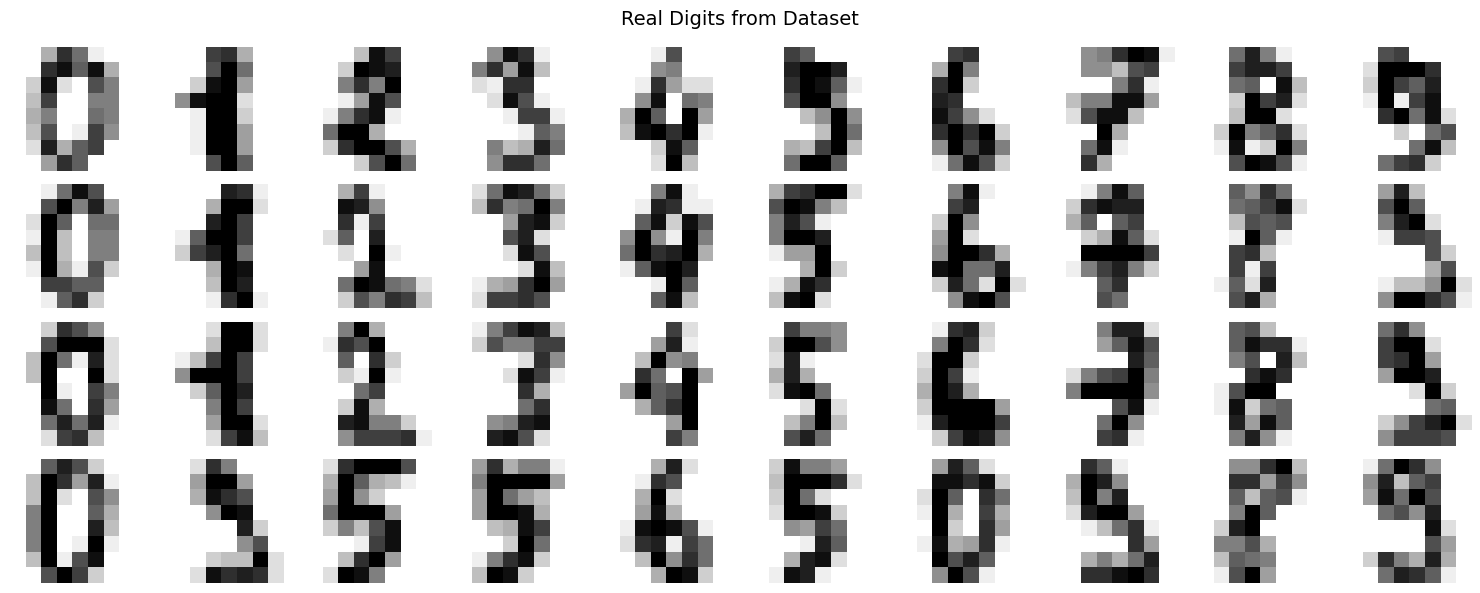

In [6]:
# 可视化真实数据样本
print("Real data samples:")
visualize_digits_grid(X[:40], title="Real Digits from Dataset", n_rows=4, n_cols=10)

## 4. 定义密度估计模型

In [7]:
models = {}

print("Initializing models...\n")

# 1. DensityForest
models['DensityForest'] = DensityForest(n_trees=50, n_min=10)
print("✓ DensityForest (n_trees=50, n_min=10)")

# 2. Single Gaussian
models['Single_Gaussian'] = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
print("✓ Single Gaussian (n_components=1)")

# 3. GMM
models['GMM_K10'] = GaussianMixture(n_components=10, covariance_type='full', random_state=42, max_iter=200)
print("✓ GMM (n_components=10)")

# 4. KDE
models['KDE'] = KernelDensity(bandwidth=2.0, kernel='gaussian')
print("✓ KDE (bandwidth=2.0)")

print(f"\nTotal models: {len(models)}")

Initializing models...

✓ DensityForest (n_trees=50, n_min=10)
✓ Single Gaussian (n_components=1)
✓ GMM (n_components=10)
✓ KDE (bandwidth=2.0)

Total models: 4


## 5. 训练模型并生成样本

In [8]:
generated_samples = {}
n_samples = 500 # 每个模型生成的样本数量

for name, model in models.items():
    print(f"\n[{name}]")
    print("  Training...", end=" ")
    model.fit(X)
    print("Done")
    
    print("  Generating samples...", end=" ")
    if name == 'DensityForest':
        generated = model.sample(n_samples=n_samples)
    elif name == 'KDE':
        generated = model.sample(n_samples=n_samples)
    else:
        generated, _ = model.sample(n_samples=n_samples)
    
    generated_samples[name] = generated
    print(f"Done (shape: {generated.shape})")

print("\n✓ All models trained and samples generated")


[DensityForest]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[Single_Gaussian]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[GMM_K10]
  Training... Done
  Generating samples... Done (shape: (500, 64))

[KDE]
  Training... Done
  Generating samples... Done (shape: (500, 64))

✓ All models trained and samples generated


## 6. 计算 MMD²

In [9]:
print("Computing kernel parameters...")

# 使用中位数启发式选择 gamma
sample_size = min(500, len(X))
X_sample = X[np.random.choice(len(X), sample_size, replace=False)]
distances = []
for i in range(min(100, sample_size)):
    for j in range(i+1, min(100, sample_size)):
        distances.append(np.linalg.norm(X_sample[i] - X_sample[j]))

median_dist = np.median(distances)
gamma_rbf = 1.0 / (2 * median_dist**2) if median_dist > 0 else 1.0 / (2 * X.shape[1])

print(f"RBF kernel gamma: {gamma_rbf:.6f}")
print(f"IMQ kernel params: c=1.0, beta=0.5\n")

results = {}

print("Computing MMD² for each model:\n")
for name, generated in generated_samples.items():
    mmd_se = compute_mmd_squared(X, generated, kernel_type='rbf', gamma=gamma_rbf)
    mmd_imq = compute_mmd_squared(X, generated, kernel_type='imq', c=1.0, beta=0.5)
    
    results[name] = {'mmd_se': mmd_se, 'mmd_imq': mmd_imq}
    
    print(f"{name:20s}  SE: {mmd_se:.6f}  IMQ: {mmd_imq:.6f}")

print("\n✓ MMD² computation complete")

Computing kernel parameters...
RBF kernel gamma: 0.000215
IMQ kernel params: c=1.0, beta=0.5

Computing MMD² for each model:

DensityForest         SE: 0.000154  IMQ: 0.000019
Single_Gaussian       SE: -0.000242  IMQ: 0.000250
GMM_K10               SE: -0.000061  IMQ: 0.000050
KDE                   SE: 0.001384  IMQ: 0.000187

✓ MMD² computation complete


## 7. 可视化生成的数字


DensityForest:


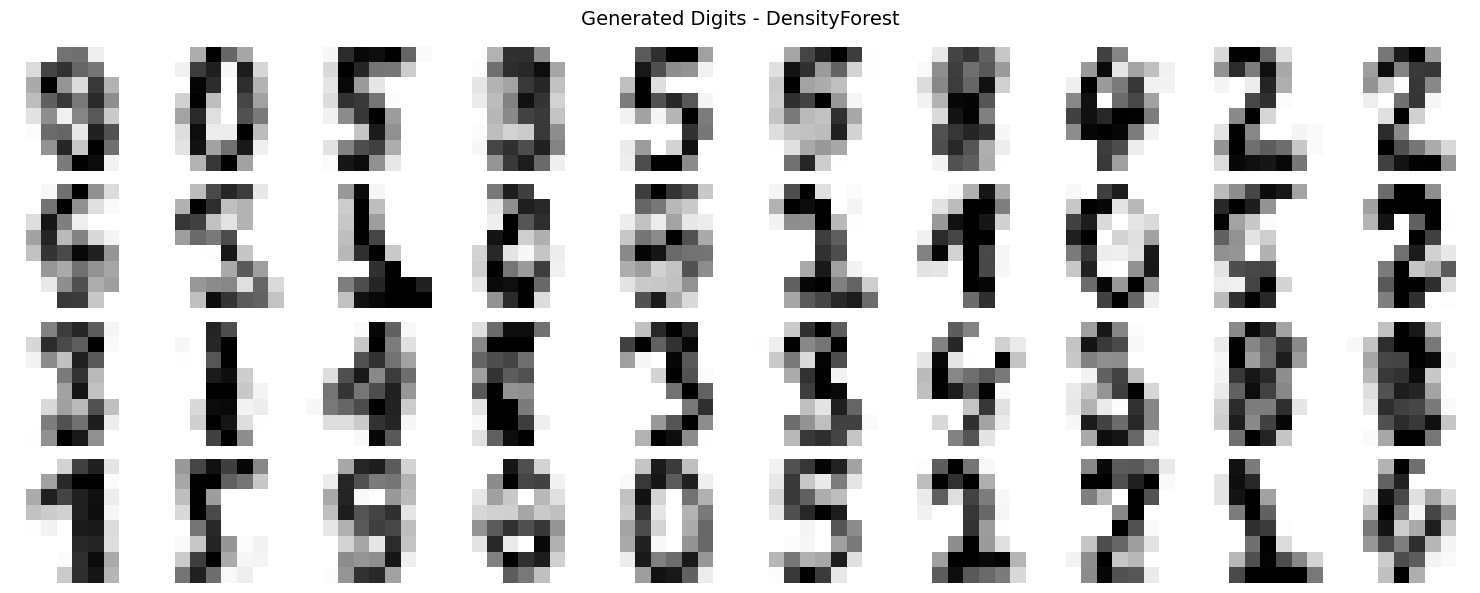


Single_Gaussian:


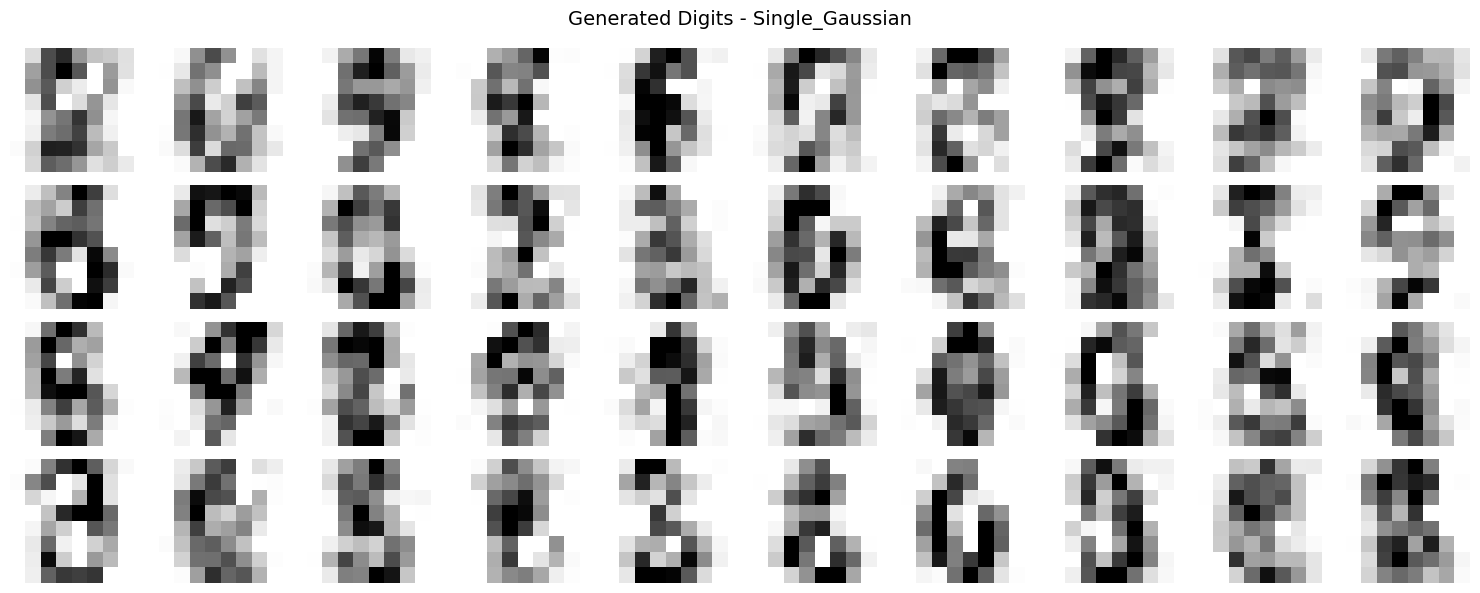


GMM_K10:


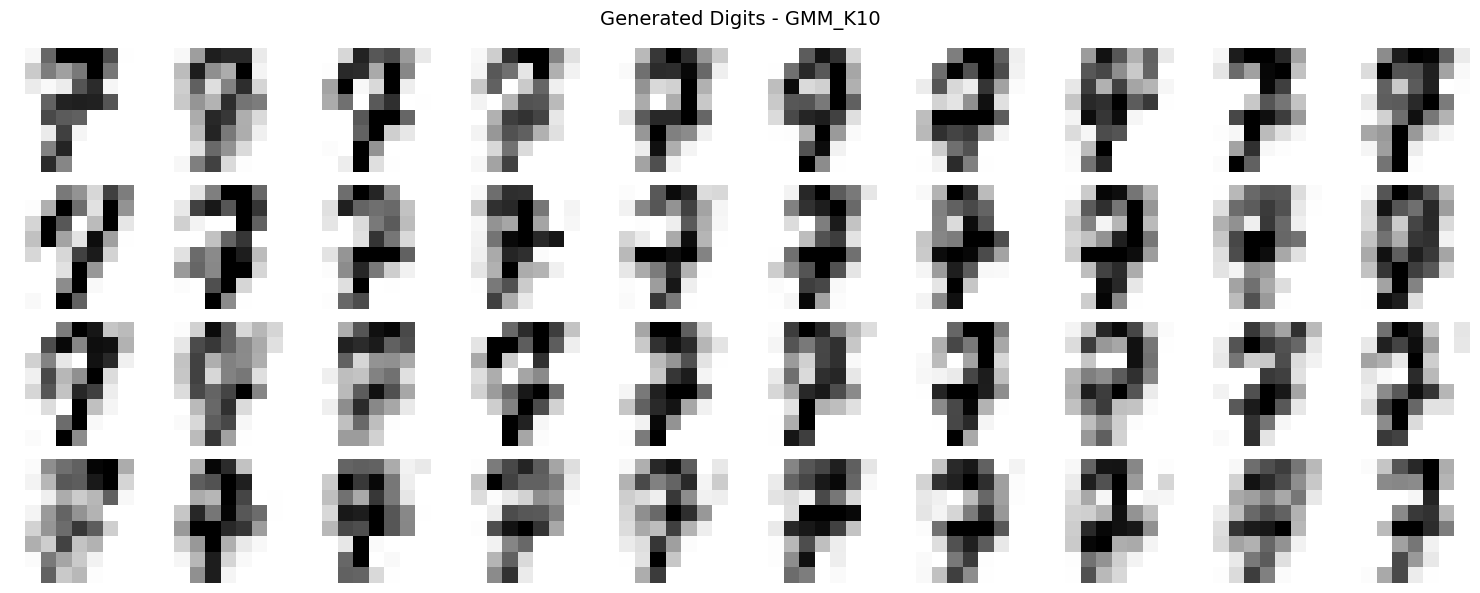


KDE:


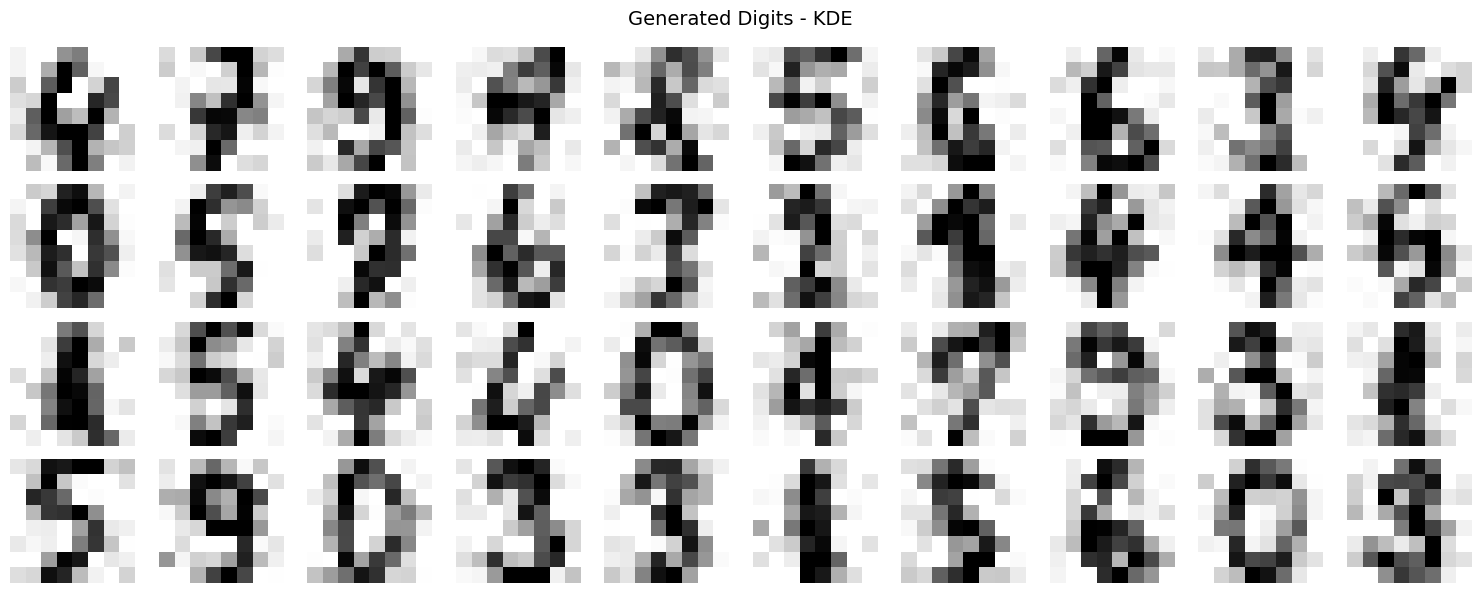

In [10]:
# 为每个模型显示生成的数字样本
for name, generated in generated_samples.items():
    print(f"\n{name}:")
    visualize_digits_grid(generated[:40], title=f"Generated Digits - {name}", n_rows=4, n_cols=10)

## 8. 可辨识性检查（RandomForest）

In [11]:
print("Training RandomForestClassifier...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"Classifier accuracy - Train: {train_acc:.4f}, Test: {test_acc:.4f}\n")
print("Evaluating generated samples...\n")

Training RandomForestClassifier...
Classifier accuracy - Train: 1.0000, Test: 0.9611

Evaluating generated samples...



In [12]:
# 评估每个模型的可辨识性
for name, generated in generated_samples.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # 预测
    pred_labels = clf.predict(generated)
    pred_proba = clf.predict_proba(generated)
    
    # 类别分布
    class_dist = Counter(pred_labels)
    print("\nClass distribution:")
    for digit in range(10):
        count = class_dist.get(digit, 0)
        percentage = count / len(generated) * 100
        bar = '█' * int(percentage / 2)
        print(f"  {digit}: {count:4d} ({percentage:5.1f}%) {bar}")
    
    # 计算指标
    expected_count = len(generated) / 10
    std_dev = np.std(list(class_dist.values()))
    uniformity = max(0, 1 - (std_dev / expected_count))
    
    max_proba = pred_proba.max(axis=1)
    avg_confidence = max_proba.mean()
    
    recognizability = (uniformity + avg_confidence) / 2
    
    print(f"\nMetrics:")
    print(f"  Uniformity:       {uniformity:.4f}")
    print(f"  Avg Confidence:   {avg_confidence:.4f}")
    print(f"  Recognizability:  {recognizability:.4f}")
    
    results[name]['recognizability'] = recognizability
    results[name]['uniformity'] = uniformity
    results[name]['confidence'] = avg_confidence

print("\n" + "="*60)


DensityForest

Class distribution:
  0:   41 (  8.2%) ████
  1:   37 (  7.4%) ███
  2:   58 ( 11.6%) █████
  3:   49 (  9.8%) ████
  4:   55 ( 11.0%) █████
  5:   44 (  8.8%) ████
  6:   30 (  6.0%) ███
  7:   64 ( 12.8%) ██████
  8:   69 ( 13.8%) ██████
  9:   53 ( 10.6%) █████

Metrics:
  Uniformity:       0.7683
  Avg Confidence:   0.6319
  Recognizability:  0.7001

Single_Gaussian

Class distribution:
  0:   27 (  5.4%) ██
  1:   20 (  4.0%) ██
  2:   57 ( 11.4%) █████
  3:   40 (  8.0%) ████
  4:   70 ( 14.0%) ███████
  5:   33 (  6.6%) ███
  6:   40 (  8.0%) ████
  7:   48 (  9.6%) ████
  8:   99 ( 19.8%) █████████
  9:   66 ( 13.2%) ██████

Metrics:
  Uniformity:       0.5515
  Avg Confidence:   0.3459
  Recognizability:  0.4487

GMM_K10

Class distribution:
  0:   52 ( 10.4%) █████
  1:   38 (  7.6%) ███
  2:   43 (  8.6%) ████
  3:   45 (  9.0%) ████
  4:   65 ( 13.0%) ██████
  5:   47 (  9.4%) ████
  6:   41 (  8.2%) ████
  7:   53 ( 10.6%) █████
  8:   65 ( 13.0%) ██████
  

## 9. 类别分布对比

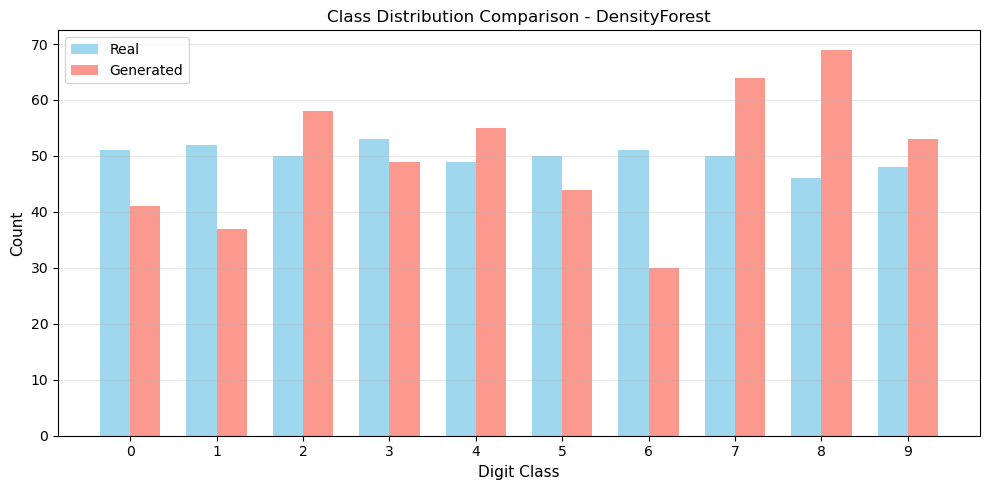

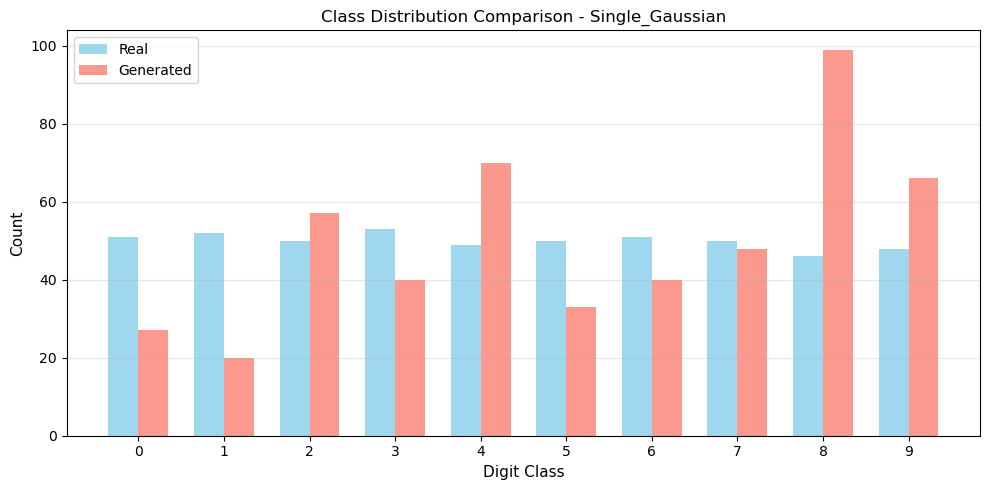

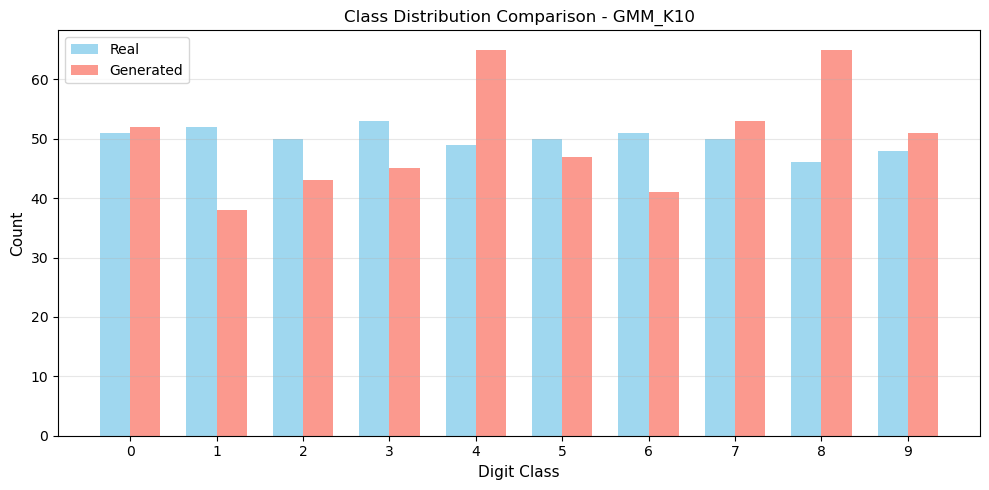

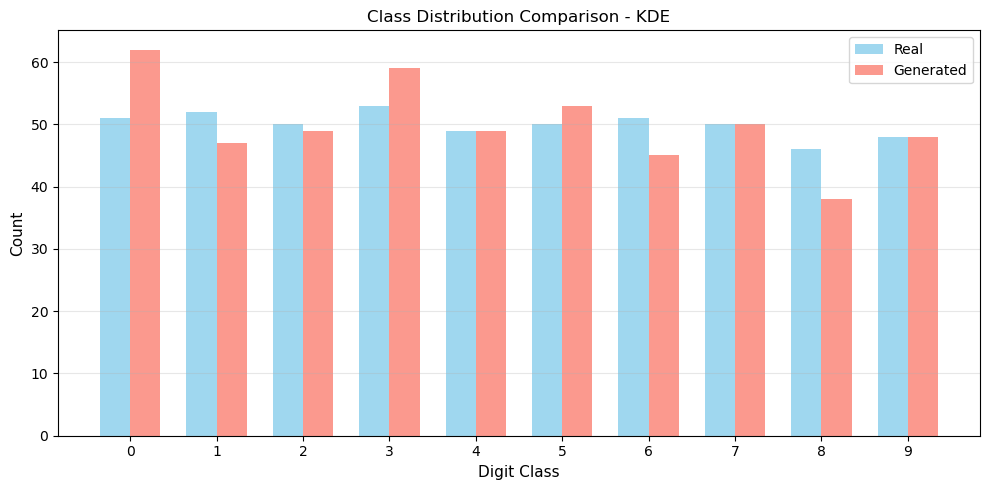

In [13]:
# 为每个模型绘制分布对比图

y_sample = y[:500]
for name, generated in generated_samples.items():
    plot_distribution_comparison(y_sample, generated, clf, name)

## 10. 结果总结

In [14]:


# 创建结果表格
print(f"\n{'Model':<20} {'MMD²(SE)':<12} {'MMD²(IMQ)':<12} {'Recogniz.':<12} {'Uniform.':<12} {'Confid.':<12}")
print("-"*80)

for name in models.keys():
    r = results[name]
    print(f"{name:<20} {r['mmd_se']:<12.6f} {r['mmd_imq']:<12.6f} {r['recognizability']:<12.4f} {r['uniformity']:<12.4f} {r['confidence']:<12.4f}")

print("\n" + "="*80)

# 找出最佳模型
best_mmd_se = min(results.items(), key=lambda x: x[1]['mmd_se'])
best_mmd_imq = min(results.items(), key=lambda x: x[1]['mmd_imq'])
best_recog = max(results.items(), key=lambda x: x[1]['recognizability'])

print("\nBest Models:")
print(f"  Lowest MMD² (SE):    {best_mmd_se[0]} ({best_mmd_se[1]['mmd_se']:.6f})")
print(f"  Lowest MMD² (IMQ):   {best_mmd_imq[0]} ({best_mmd_imq[1]['mmd_imq']:.6f})")
print(f"  Highest Recognizability: {best_recog[0]} ({best_recog[1]['recognizability']:.4f})")

print("\n" + "="*80)


Model                MMD²(SE)     MMD²(IMQ)    Recogniz.    Uniform.     Confid.     
--------------------------------------------------------------------------------
DensityForest        0.000154     0.000019     0.7001       0.7683       0.6319      
Single_Gaussian      -0.000242    0.000250     0.4487       0.5515       0.3459      
GMM_K10              -0.000061    0.000050     0.7440       0.8243       0.6637      
KDE                  0.001384     0.000187     0.7252       0.8707       0.5796      


Best Models:
  Lowest MMD² (SE):    Single_Gaussian (-0.000242)
  Lowest MMD² (IMQ):   DensityForest (0.000019)
  Highest Recognizability: GMM_K10 (0.7440)



## 说明

### 评估指标

**MMD²（Maximum Mean Discrepancy）**：
- 衡量生成分布与真实分布的差异
- 值越小越好（0 表示完全相同）
- SE核和IMQ核从不同角度评估分布相似度

**可辨识性（Recognizability）**：
- 使用RandomForest分类器评估生成数字的质量
- 综合考虑类别分布均匀性和预测置信度
- 值越高表示生成的数字越清晰可辨

**分布均匀性（Uniformity）**：
- 检查10个数字类别的生成是否均衡
- 值接近1表示每个数字生成数量相近

**预测置信度（Confidence）**：
- 分类器识别生成数字的确定性
- 值越高表示生成的数字越清晰